In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model

# === Load the data in chunks ===
chunks = []
for chunk in pd.read_csv("all_stocks_index_1min_preprocess.csv", chunksize=50_000):
    chunks.append(chunk)
    if len(chunks) == 3:  # Load ~150,000 rows
        break

df = pd.concat(chunks, ignore_index=True)

# === Feature selection ===
features = ['open', 'high', 'low', 'close', 'volume',
            'SMA_10', 'EMA_9', 'EMA_21', 'RSI_14', 'MA_20',
            'BB_Upper', 'BB_Lower', 'EMA_12', 'EMA_26',
            'MACD', 'Signal_Line', '%K', '%D', 'ATR_14']

df = df[features].dropna()

# === Scaling ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=features)

# === Prepare target (next time step's close price) ===
target = df['close'].shift(-1).values[:-1]
scaled_df = scaled_df[:-1]  # drop last row to align with target

# === Sequence creation function ===
def create_sequences(data, target, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps].astype(np.float32))
        y.append(np.float32(target[i+time_steps]))
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df.values, target, time_steps=60)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === Transformer model ===
def transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Self-attention block
    attention = MultiHeadAttention(num_heads=4, key_dim=input_shape[-1])(inputs, inputs)
    attention = Dropout(0.1)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    # Feed-forward block
    ff = Dense(128, activation='relu')(attention)
    ff = Dropout(0.1)(ff)
    ff = Dense(input_shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(ff + attention)

    # Output
    flat = tf.keras.layers.Flatten()(ff)
    output = Dense(1)(flat)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

# === Build and train the model with error handling ===
model = transformer_model(X_train.shape[1:])
model.summary()

try:
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,  # reduced for memory efficiency
        validation_split=0.1,
        verbose=1
    )
except Exception as e:
    print(f"Training failed due to error: {e}")

# === Evaluate the model ===
loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss (MSE): {loss:.4f}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 19)    │      6,023 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 19)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 19)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 19)    │         38 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 128)   │      2,560 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60, 19)    │      2,451 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 19)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 19)    │         38 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1140)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      1,141 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 0.0259 - val_loss: 1.3725e-05
Epoch 2/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 2.1756e-04 - val_loss: 3.5553e-04
Epoch 3/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 6.3624e-05 - val_loss: 5.1381e-05
Epoch 4/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 1.4132e-05 - val_loss: 6.2032e-06
Epoch 5/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - loss: 2.5311e-06 - val_loss: 1.7245e-07
Epoch 6/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 6.8931e-07 - val_loss: 7.9103e-08
Epoch 7/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - loss: 3.6590e-07 - val_loss: 1.4333e-06
Epoch 8/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 9.6561e-07 - val_loss: 3.7675e-07
Epoch 9/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 3.1177e-07 - val_loss: 5.7134e-07
Epoch 10/10
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - loss: 3.0793e-07 - val_loss: 3.5074e-08
937/937 ━━━━━━━━━━━━━━━

937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


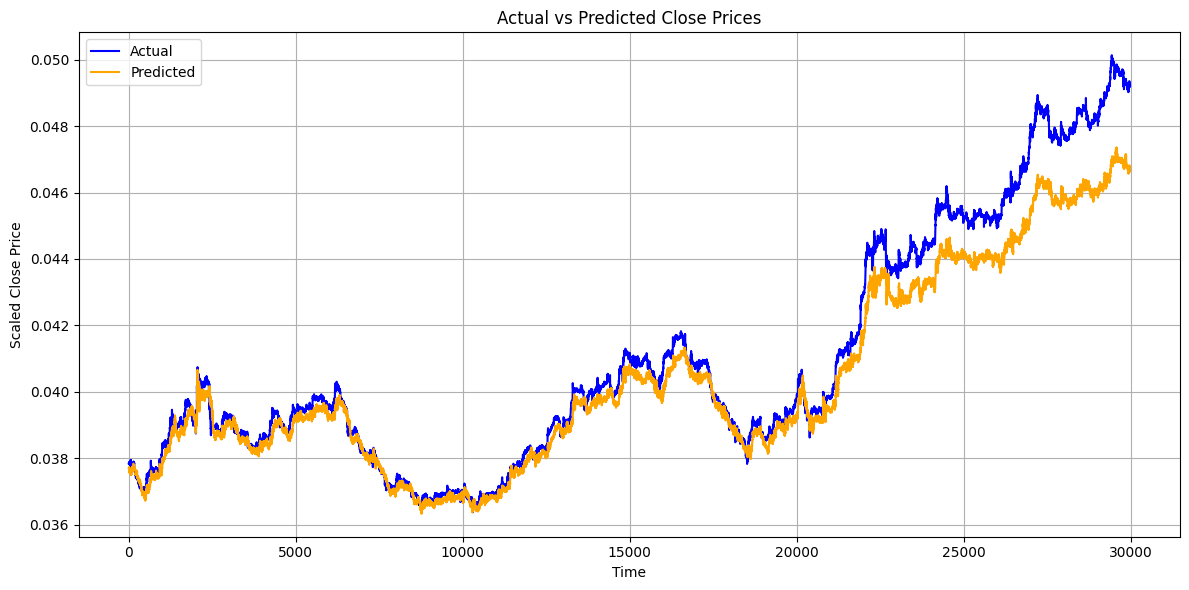

In [2]:
import matplotlib.pyplot as plt

# === Predict on test data ===
y_pred = model.predict(X_test)

# === Plot actual vs predicted ===
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predict on test set
y_pred = model.predict(X_test).flatten()  # Flatten if needed

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
R² Score: 0.9294
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006


In [5]:
model.save("tranformer_stock_model.keras")